# WAMBS BRMS Tutorial: Popularity Data

**Authors**: original R Tutorial created by Laurent Smeets and Rens van de Schoot, with updates by Duco Veen; Python translation by Florian Metwaly.

## Introduction

In this tutorial you follow the steps of the when-to-Worry-and-How-to-Avoid-the-Misuse-of-Bayesian-Statistics - checklist [(the WAMBS-checklist)](https://www.rensvandeschoot.com/wambs-checklist/).

## **WAMBS checklist**

### *When to worry, and how to Avoid the Misuse of Bayesian Statistics*

**To be checked before estimating the model**

1. Do you understand the priors?

**To be checked after estimation but before inspecting model results**

2. Does the trace-plot exhibit convergence?
3. Does convergence remain after doubling the number of iterations?
4.   Does the posterior distribution histogram have enough information?
5.   Do the chains exhibit a strong degree of autocorrelation?
6.   Do the posterior distributions make substantive sense?

**Understanding the exact influence of the priors**

7. Do different specification of the multivariate variance priors influence the results?
8.   Is there a notable effect of the prior when compared with non-informative priors?
9.   Are the results stable from a sensitivity analysis?
10.   Is the Bayesian way of interpreting and reporting model results used?


## Packages and Data

The main package that is used for this analysis is [bambi](https://bambinos.github.io/bambi/). For more information and a tutorial on how to install these please have a look at: https://bambinos.github.io/bambi/. The bambi library is build on [PyMC](https://www.pymc.io/welcome.html). PyMC is a probabilistic programming library for Python, which implements many of the features of STAN. If you encounter performance issues, before installing bambi, install PyMC following their guide: https://www.pymc.io/projects/docs/en/stable/installation.html.

If you are using Google Colab, remove the `#` and run the following lines to install the needed libraries

In [ ]:
#!pip install bambi

After you have installed `bambi`, you need to load some more libraries that we need for this tutorial.

In [1]:
import bambi as bmb # BAyesian Model-Building Interface in Python
import arviz as az # Exploratory analysis of Bayesian models
import pandas as pd
import requests
import matplotlib.pyplot as plt # plotting

SEED = 1337

To download the popularity data go to https://github.com/MirjamMoerbeek/Data_Sets_ML_book/blob/main/popular2.sav. We will use the .sav file which can be found in the SPSS folder. After downloading the data to your working directory you can open it with the `pandas` library using the `pd.read_spss()` command.

Alternatively, you can directly download them from GitHub into your working directory using the following command (this also works well if you are on Google Colab!):

In [2]:
url = "https://github.com/MirjamMoerbeek/Data_Sets_ML_book/raw/main/popular2.sav"

# Download the file
with open("popular2.sav", "wb") as f:
    response = requests.get(url)
    response.raise_for_status()
    f.write(response.content)

In [3]:
popular2data = pd.read_spss("popular2.sav")

There are some variables in the dataset that we do not use, so we can select the variables we will use and have a look at the first few observations:

In [4]:
# We select just the variables we will use
popular2data = popular2data[["pupil", "class", "extrav", "sex", "texp", "popular"]]

# Display the first 6 observations
popular2data.head(6)

,pupil,class,extrav,sex,texp,popular
0,1.0,1.0,5.0,girl,24.0,6.3
1,2.0,1.0,7.0,boy,24.0,4.9
2,3.0,1.0,4.0,girl,24.0,5.3
3,4.0,1.0,3.0,girl,24.0,4.7
4,5.0,1.0,5.0,girl,24.0,6.0
5,6.0,1.0,4.0,boy,24.0,4.7


## The model

For this tutorial we make use of the multilevel crosslevel model (Model M2 from Table 2.3 in the book) we developed in the bambi tutorial. We have a main effect of sex, a random effect of Extravesion and a cross-level interaction between Extraversion and Teacher experience. This means we have to add texp as a predictor for the coefficient of extrav The cross level interaction term between extraversion and teacher experience can be created by the ':' sign or by multiplying the terms.

If we put all of this in formula form we get: $Popularity_{ij}=\beta_{0j}+\beta_1*gender_{ij}+ \beta_{2j}*extraversion_{ij}+e_{ij}$.

In which $\beta_{0j}=\gamma_{00}+\gamma_{01}*experience_j+u_{0j}$  and  $\beta_{2j}= \gamma_{20}+\gamma_{21}*experience_j+u_{2j}$

Combined we get:

$$Popularity_{ij}= \gamma_{00}+\gamma_{10}*sex_{ij}+\gamma_{20}*extraversion_{ij}+\gamma_{01}*experience_j+\gamma_{21}*extraversion_{ij}*experience_j+u_{2j}*extraversion_{ij}+u_{0j}+e_{ij}$$


### 1.Do you understand the priors?

By building the model using the `model.build()` command, you can inspect the prior specification of the model without fitting the model.

In [5]:
# Step 1: Define the model (but don't fit yet!)
model = bmb.Model(
    "popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)",
    data=popular2data,
    center_predictors=False
)

# Step 2: Build the model to resolve and assign default priors (this is still not fitting the model!)
model.build()

# Step 3: Inspect the priors
model

       Formula: popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)
        Family: gaussian
          Link: mu = identity
  Observations: 2000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 5.0764, sigma: 18.3381)
            sex ~ Normal(mu: 0.0, sigma: 6.9113)
            extrav ~ Normal(mu: 0.0, sigma: 2.738)
            texp ~ Normal(mu: 0.0, sigma: 0.5275)
            extrav:texp ~ Normal(mu: 0.0, sigma: 0.101)
        
        Group-level effects
            1|class ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 18.3381))
            extrav|class ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.738))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.3822)

In this tutorial we will only specify priors for:

1. The regression coefficient of extrav $\gamma_{20}$
2. The regression coefficient of sex $\gamma_{10}$
3. The regression coefficient of texp $\gamma_{01}$
4. The regression coefficient of extrav:texp  $\gamma_{21}$
5. The intercept  $\gamma_{00}$

Since we are using a interaction effect and we are working with uncentered independent variables, the intercept will no longer be just a mean, but the value when all other values are zero even if this are impossible values. We can therefore not be very sure about the intercept and therefore we will give it a cauchy distribution with a shape parameter of 10. Based on earlier literature we might be fairly sure that that girls have a higher popularity than boys and will thus give its regression coefficient a normal distribution with a mean of 2 and a sigma (standard deviation) of .2. For teacher experience and extraverion we might be a bit less sure, because we are using interaction effects for these which means that the individual effects of these independent variables are now dependent on each other. Because of that, we decide to pick a wide normal distribution with a mean of 0 and a sigma (standard deviation) of 5. We are fairly sure about a negative interaction effect so we pick a normal distribution with a mean of -1 and a sigma (standard deviation) of .3 for the regression coefficient of extrav:texp.


In [46]:
priors = {
    "Intercept": bmb.Prior("Cauchy", alpha=0, beta=10),
    "sex": bmb.Prior("Normal", mu=2, sigma=0.2),
    "extrav": bmb.Prior("Normal", mu=0, sigma=5),
    "texp": bmb.Prior("Normal", mu=0, sigma=5),
    "extrav:texp": bmb.Prior("Normal", mu=-1, sigma=0.3),
}

In [47]:
# Define model
model = bmb.Model(
    "popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)",
    data=popular2data,
    priors=priors,
    center_predictors=False
)

# Fit model
fit = model.fit(
    draws=3000,
    tune=1000,
    chains=3,
    cores=3,
    random_seed=SEED,
    target_accept=0.96)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, sex, extrav, texp, extrav:texp, 1|class_sigma, 1|class_offset, extrav|class_sigma, extrav|class_offset]


Output()

Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 108 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


### 2. Does the trace-plot exhibit convergence?

Before interpreting results, one should inspect the convergence of the chains that form the posterior distribution of the model parameters. A straightforward and common way to visualize convergence is the trace plot that illustrates the iterations of the chains from start to end.


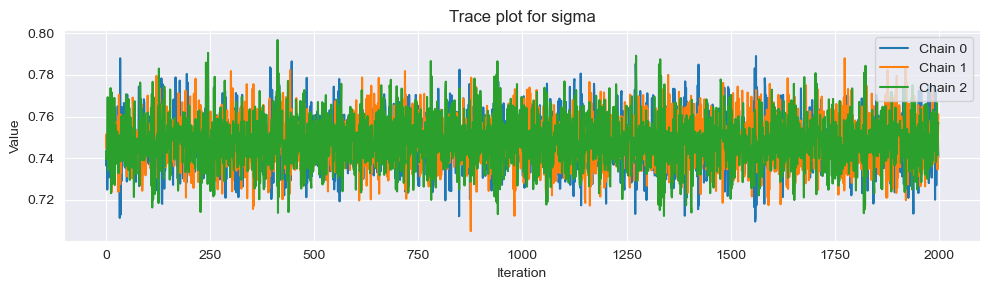

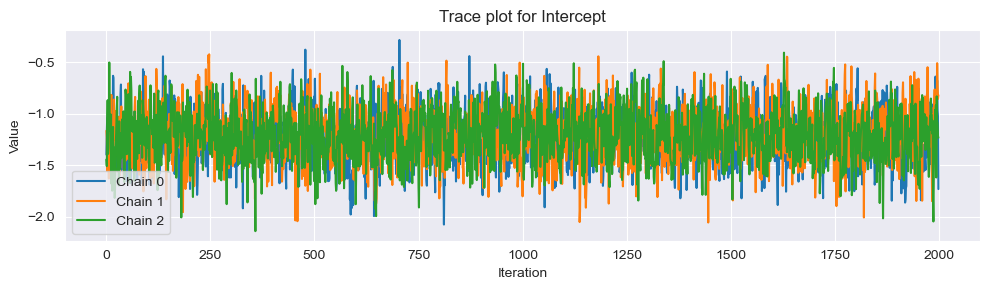

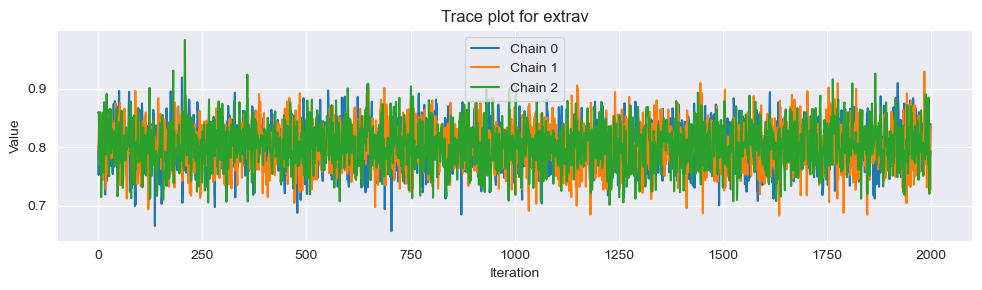

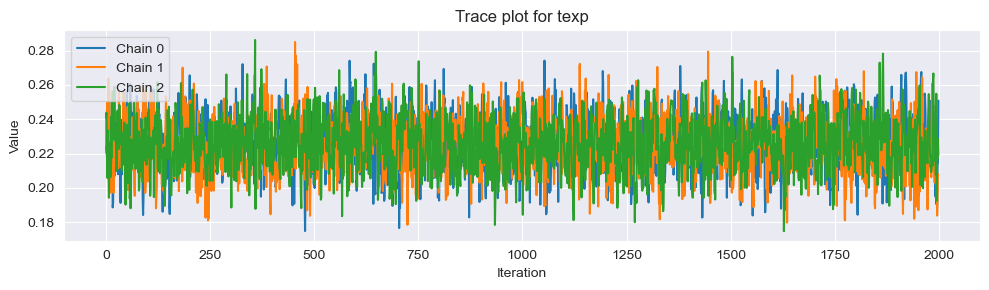

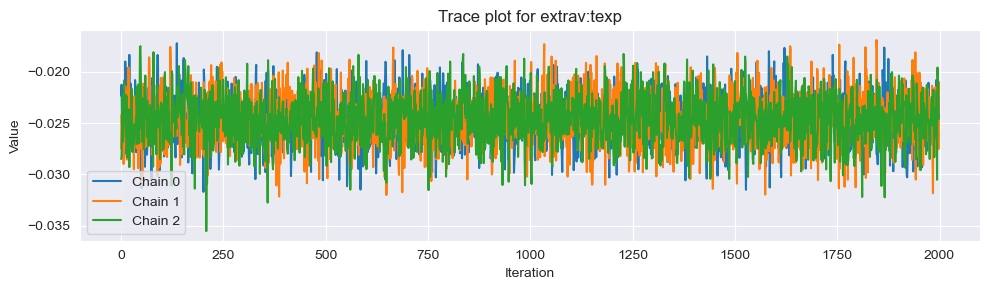

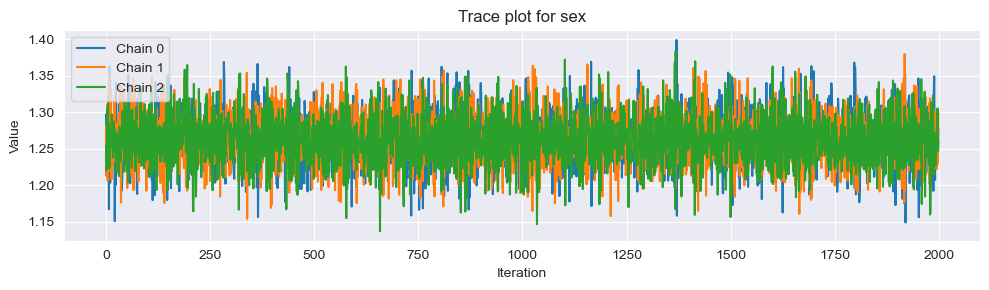

In [16]:
# Extract the posterior samples
samples = fit.posterior

# Store variable names
parameters = ["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"]

# Plot each parameters trace plot
for param in parameters:
    values = samples[param]
    plt.figure(figsize=(10, 3))
    for chain in range(values.shape[0]):
        plt.plot(values[chain].values, label=f"Chain {chain}")
    plt.title(f"Trace plot for {param}")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

Alternatively, you can simply make use of the `arviz` library to get the trace plots (and other convergence statistics).

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'extrav'}>,
        <Axes: title={'center': 'extrav'}>],
       [<Axes: title={'center': 'texp'}>,
        <Axes: title={'center': 'texp'}>],
       [<Axes: title={'center': 'extrav:texp'}>,
        <Axes: title={'center': 'extrav:texp'}>],
       [<Axes: title={'center': 'sex'}>, <Axes: title={'center': 'sex'}>]],
      dtype=object)

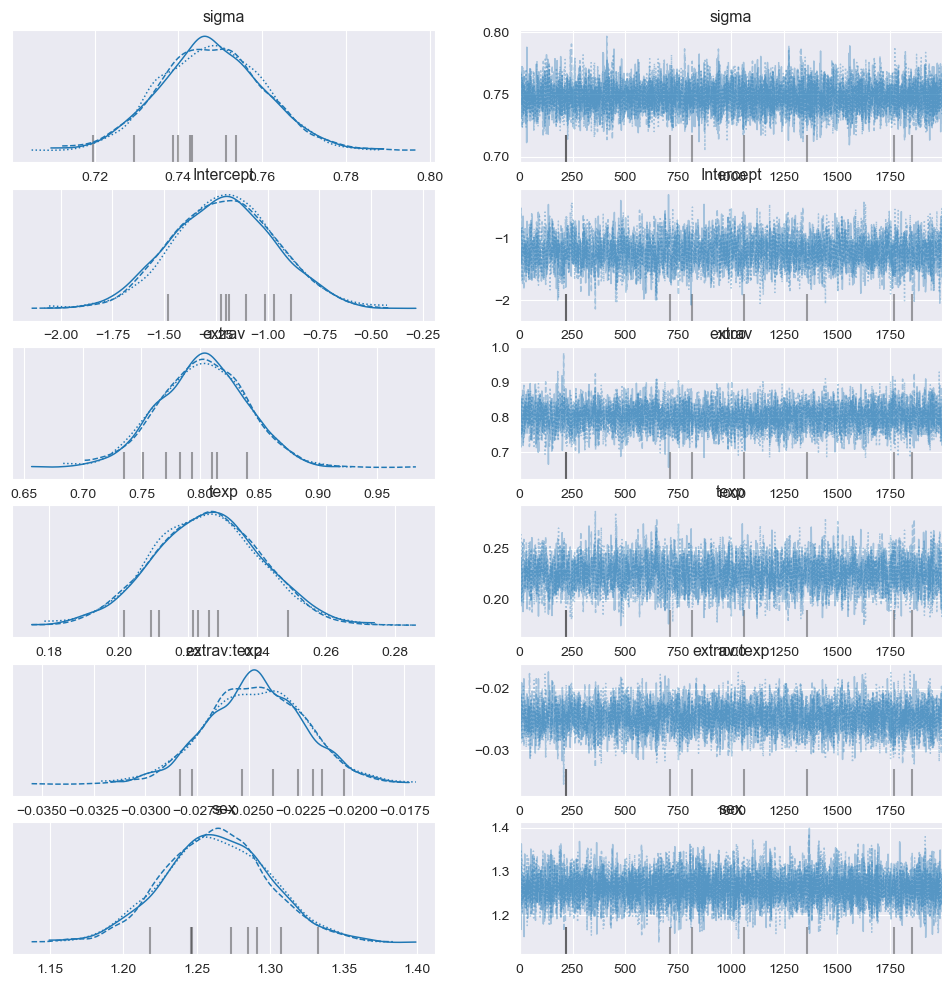

In [18]:
az.plot_trace(fit, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

It seems like the trace (caterpillar) plots are not neatly converged into one each other (we ideally want one fat caterpillar, like the one for `sigma`). This indicates we need more samples. Additionally, we get the marginal posterior distribution for each chain, in which we can also see that the sampled posteriors differ slightly between the chains, indicating that the sampler hasn't fully converged.

We can check if the chains have reached convergence by having a look at the convergence diagnostics. Two of these diagnostics of interest include the Gelman and Rubin diagnostic and the Effective Sample Size (ESS).

* The Gelman-Rubin Diagnostic shows the potential scale reduction factor (PSRF) values (using the  within and between chain variability), which all should be close to 1 ($\geq 1.01$). If they aren't close to 1, you should use more iterations. Note: The Gelman and Rubin diagnostic is also automatically given in the summary provided by `bambi` under the column `r_hat`.
* The Effective Sample Size (ESS) estimates how many independent samples your MCMC chain is equivalent to, after accounting for autocorrelation. A high ESS means your samples provide a lot of usable information. If ESS is low, it indicates poor mixing, and you may need to run the chain longer.

To obtain the Gelman and Rubin diagnostic use:

In [20]:
az.rhat(fit, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

<xarray.Dataset> Size: 64B
Dimensions:      (sex_dim: 1)
Coordinates:
  * sex_dim      (sex_dim) <U4 16B 'girl'
Data variables:
    sigma        float64 8B 1.003
    Intercept    float64 8B 1.0
    extrav       float64 8B 1.0
    texp         float64 8B 1.0
    extrav:texp  float64 8B 1.001
    sex          (sex_dim) float64 8B 1.001

Additionally we can use rank plots. Rank plots are histograms of ranked posterior draws, plotted separately for each chain. The rank plots should show a uniform distribution.

array([[<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'Intercept'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'extrav'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'texp'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'extrav:texp'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sex\ngirl'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

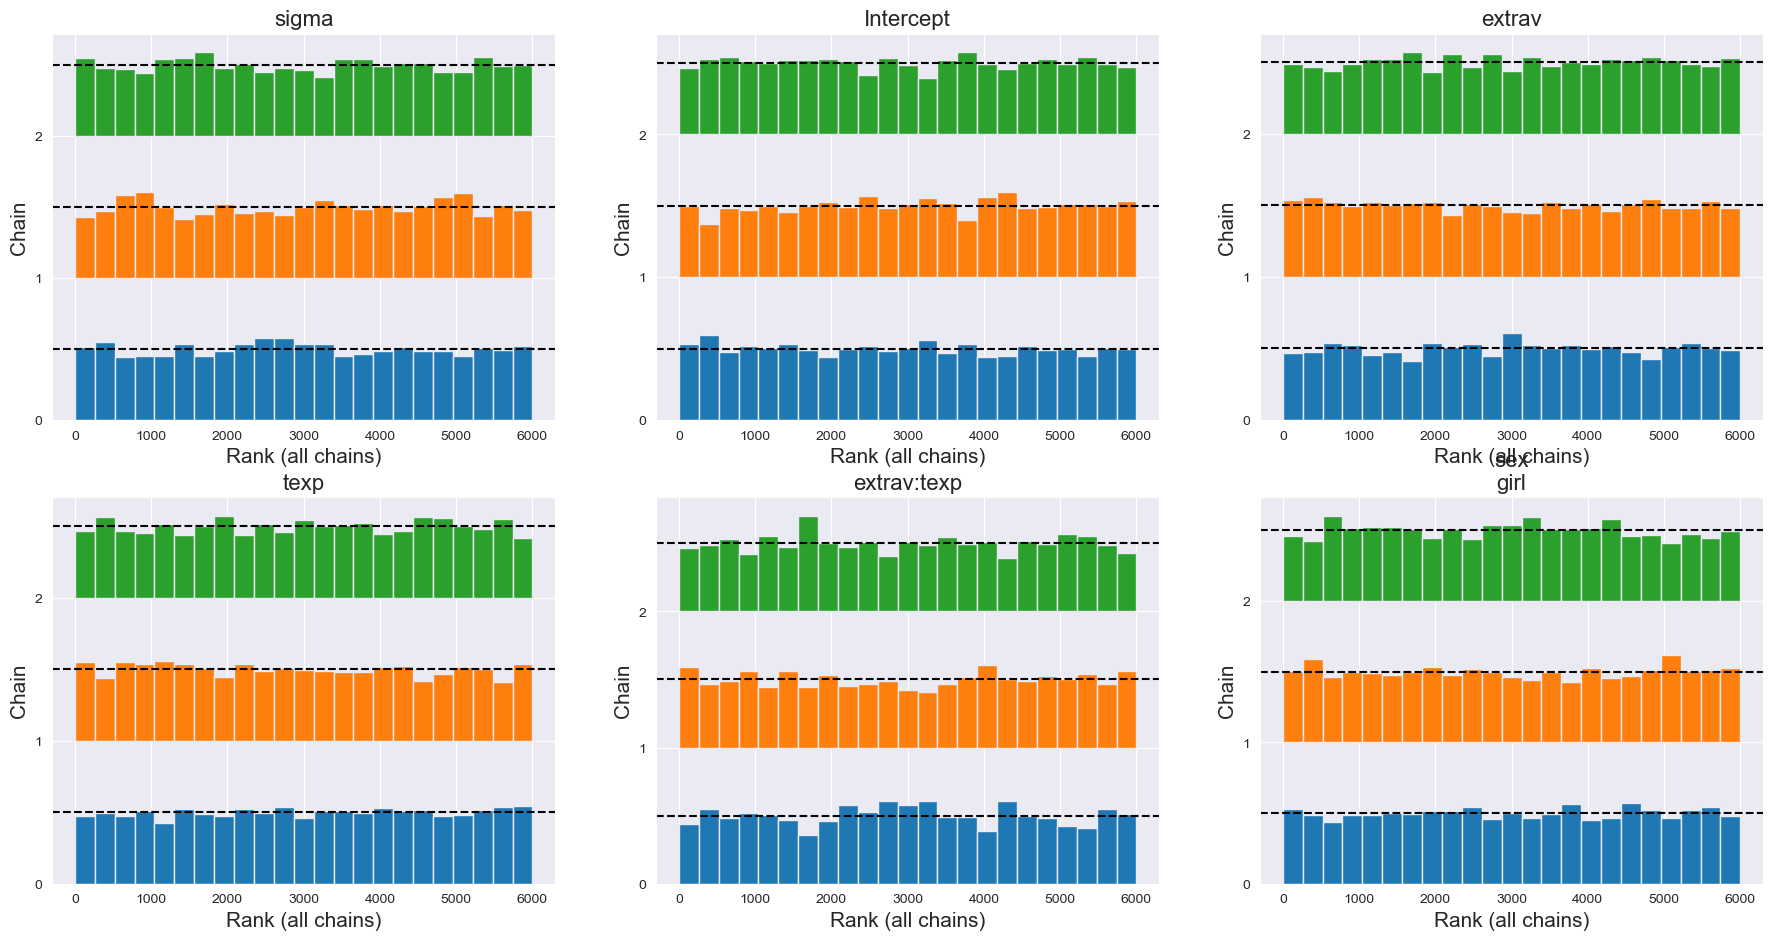

In [21]:
az.plot_rank(fit, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

To obtain the ESS use:

In [22]:
az.ess(fit, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

<xarray.Dataset> Size: 64B
Dimensions:      (sex_dim: 1)
Coordinates:
  * sex_dim      (sex_dim) <U4 16B 'girl'
Data variables:
    sigma        float64 8B 1.163e+04
    Intercept    float64 8B 2.801e+03
    extrav       float64 8B 4.328e+03
    texp         float64 8B 2.698e+03
    extrav:texp  float64 8B 4.123e+03
    sex          (sex_dim) float64 8B 1.235e+04

Now we see that the Gelman and Rubin diagnostic (PRSF) is close to 1 for all parameters and the ESS is sufficiently high.

### 3. Does convergence remain after doubling the number of iterations?

As is recommended in the WAMBS checklist, we double the amount of iterations to check for local convergence.

In [23]:
# Fit model with double the iterations
fit_doubleiter = model.fit(
    draws=6000,
    tune=2000,
    chains=3,
    cores=3,
    random_seed=SEED,
    target_accept=0.96)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, sex, extrav, texp, extrav:texp, 1|class_sigma, 1|class_offset, extrav|class_sigma, extrav|class_offset]


Output()

Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 182 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [24]:
az.rhat(fit_doubleiter, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

<xarray.Dataset> Size: 64B
Dimensions:      (sex_dim: 1)
Coordinates:
  * sex_dim      (sex_dim) <U4 16B 'girl'
Data variables:
    sigma        float64 8B 1.0
    Intercept    float64 8B 1.0
    extrav       float64 8B 1.0
    texp         float64 8B 1.0
    extrav:texp  float64 8B 1.0
    sex          (sex_dim) float64 8B 0.9999

array([[<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'Intercept'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'extrav'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'texp'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'extrav:texp'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sex\ngirl'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

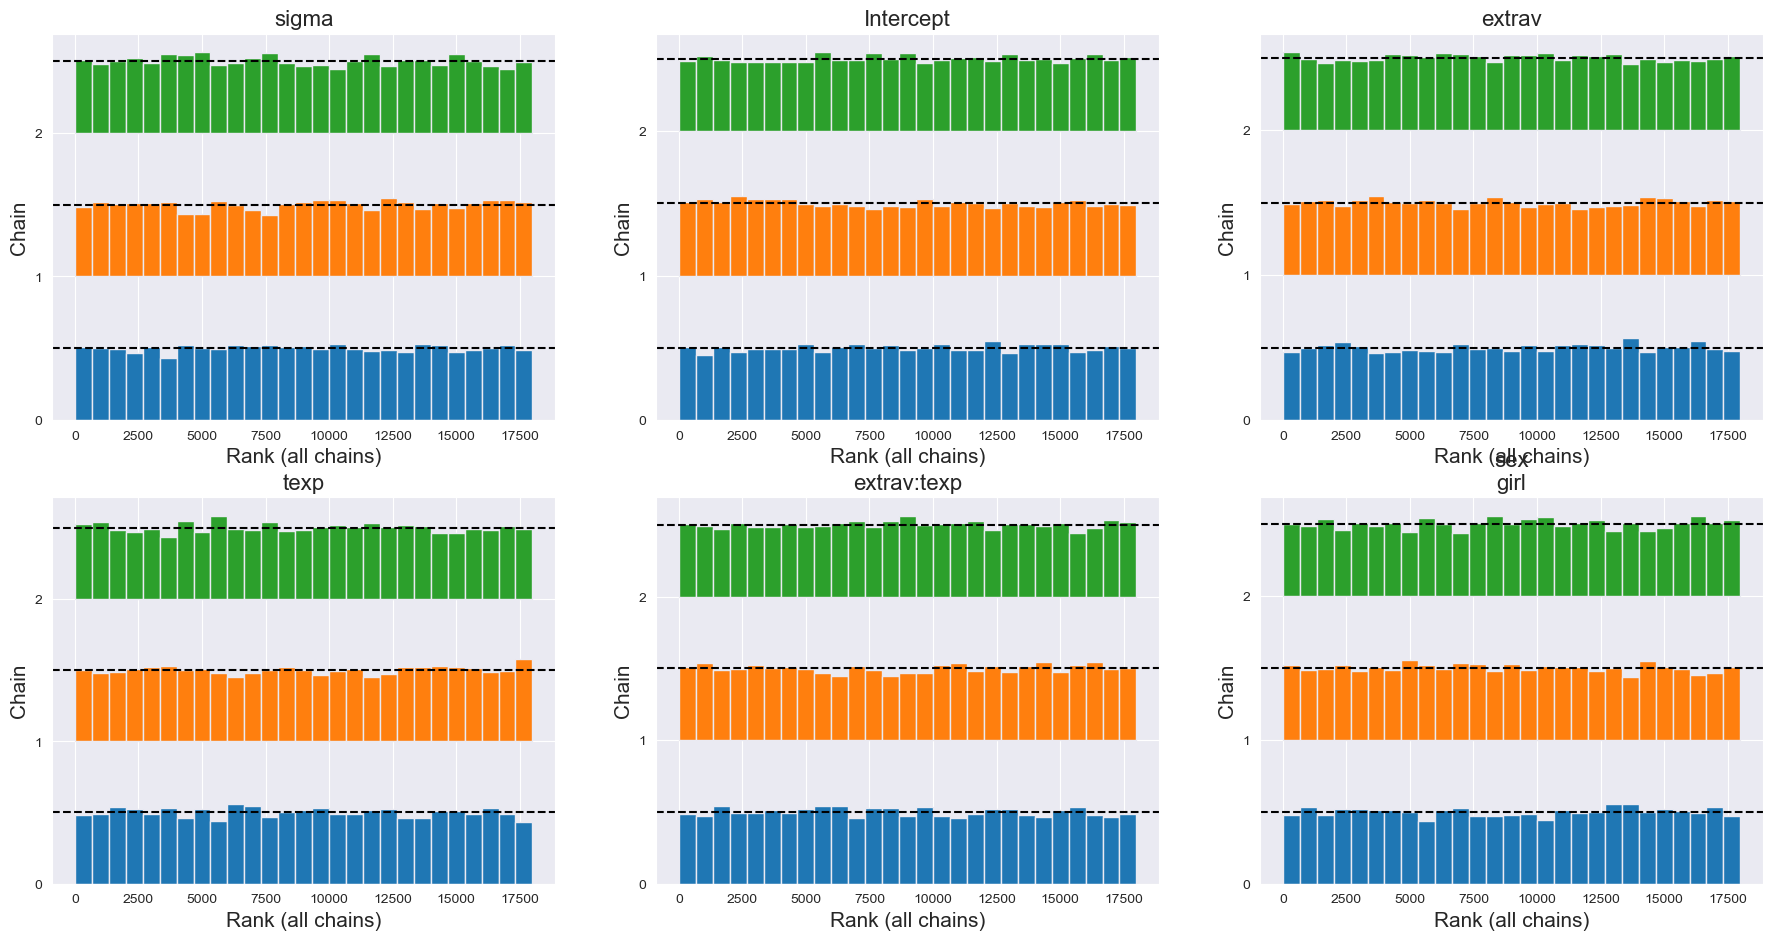

In [25]:
az.plot_rank(fit_doubleiter, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

You should again have a look at the above-mentioned convergence statistics, but we can also compute the relative bias to inspect if doubling the number of iterations influences the posterior parameter estimates ($bias= 100*\frac{(model \; with \; double \; iteration \; - \; initial \; converged \; model )}{initial \; converged \; model}$). In order to preserve clarity we  just calculate the bias of the two regression coefficients.

You should combine the relative bias in combination with substantive knowledge about the metric of the parameter of interest to determine when levels of relative deviation are negligible or problematic. For example, with a regression coefficient of 0.001, a 5% relative deviation level might not be substantively relevant. However, with an intercept parameter of 50, a 10% relative deviation level might be quite meaningful. The specific level of relative deviation should be interpreted in the substantive context of the model. Some examples of interpretations are:

- if relative deviation is &lt; |5|%, then do not worry;
- if relative deviation &gt; |5|%, then rerun with 4x nr of iterations.


In [49]:
# Get posterior summaries
summary_fit = az.summary(fit, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])
summary_fit_doubleiter = az.summary(fit_doubleiter, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

# Extract posterior means
means_fit = summary_fit["mean"]
means_fit_doubleiter = summary_fit_doubleiter["mean"]

# Compute % change
percent_change = 100 * ((means_fit_doubleiter - means_fit) / means_fit)
percent_change_rounded = percent_change.round(4)

print(percent_change_rounded)

sigma          0.0000
Intercept      0.1653
extrav        -0.1245
texp           0.0000
extrav:texp   -0.0000
sex[girl]      0.0000
Name: mean, dtype: float64


The relative bias is small enough (<5%) not worry about it

### 4.   Does the posterior distribution histogram have enough information?

By having a look at the postrior distribution density (or if you like histogram) we can check if it has enough information. For regression coefficients it ideally it is clearly centerered with smooth sloping tails.

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'extrav'}>],
       [<Axes: title={'center': 'texp'}>,
        <Axes: title={'center': 'extrav:texp'}>,
        <Axes: title={'center': 'sex\ngirl'}>]], dtype=object)

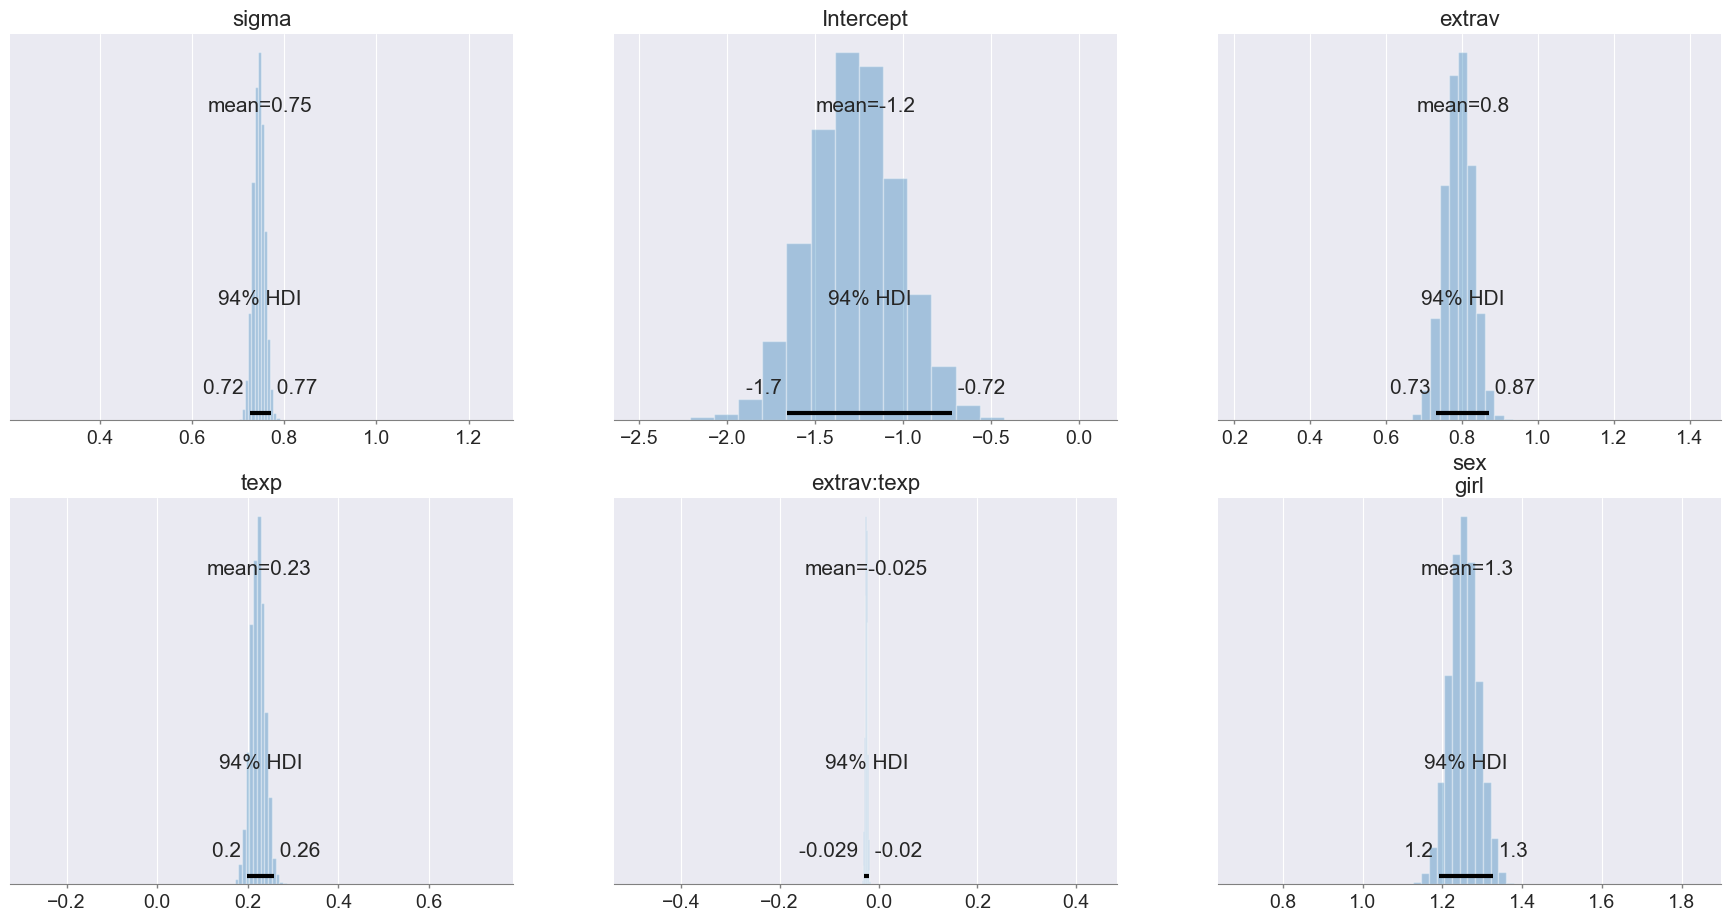

In [29]:
az.plot_posterior(fit, kind="hist", var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

The different posterior distributions have enough information and more iterations are not necessary. They are all single peaked with smooth slopes. Posterior distributions do not have to be symmetrical, but  in this example they seem to be.

### 5.   Do the chains exhibit a strong degree of autocorrelation?

To obtain information about autocorrelation the following syntax can be used:

array([[<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>],
       [<Axes: title={'center': 'Intercept\n0'}>,
        <Axes: title={'center': 'Intercept\n1'}>,
        <Axes: title={'center': 'Intercept\n2'}>],
       [<Axes: title={'center': 'extrav\n0'}>,
        <Axes: title={'center': 'extrav\n1'}>,
        <Axes: title={'center': 'extrav\n2'}>],
       [<Axes: title={'center': 'texp\n0'}>,
        <Axes: title={'center': 'texp\n1'}>,
        <Axes: title={'center': 'texp\n2'}>],
       [<Axes: title={'center': 'extrav:texp\n0'}>,
        <Axes: title={'center': 'extrav:texp\n1'}>,
        <Axes: title={'center': 'extrav:texp\n2'}>],
       [<Axes: title={'center': 'sex\n0, girl'}>,
        <Axes: title={'center': 'sex\n1, girl'}>,
        <Axes: title={'center': 'sex\n2, girl'}>]], dtype=object)

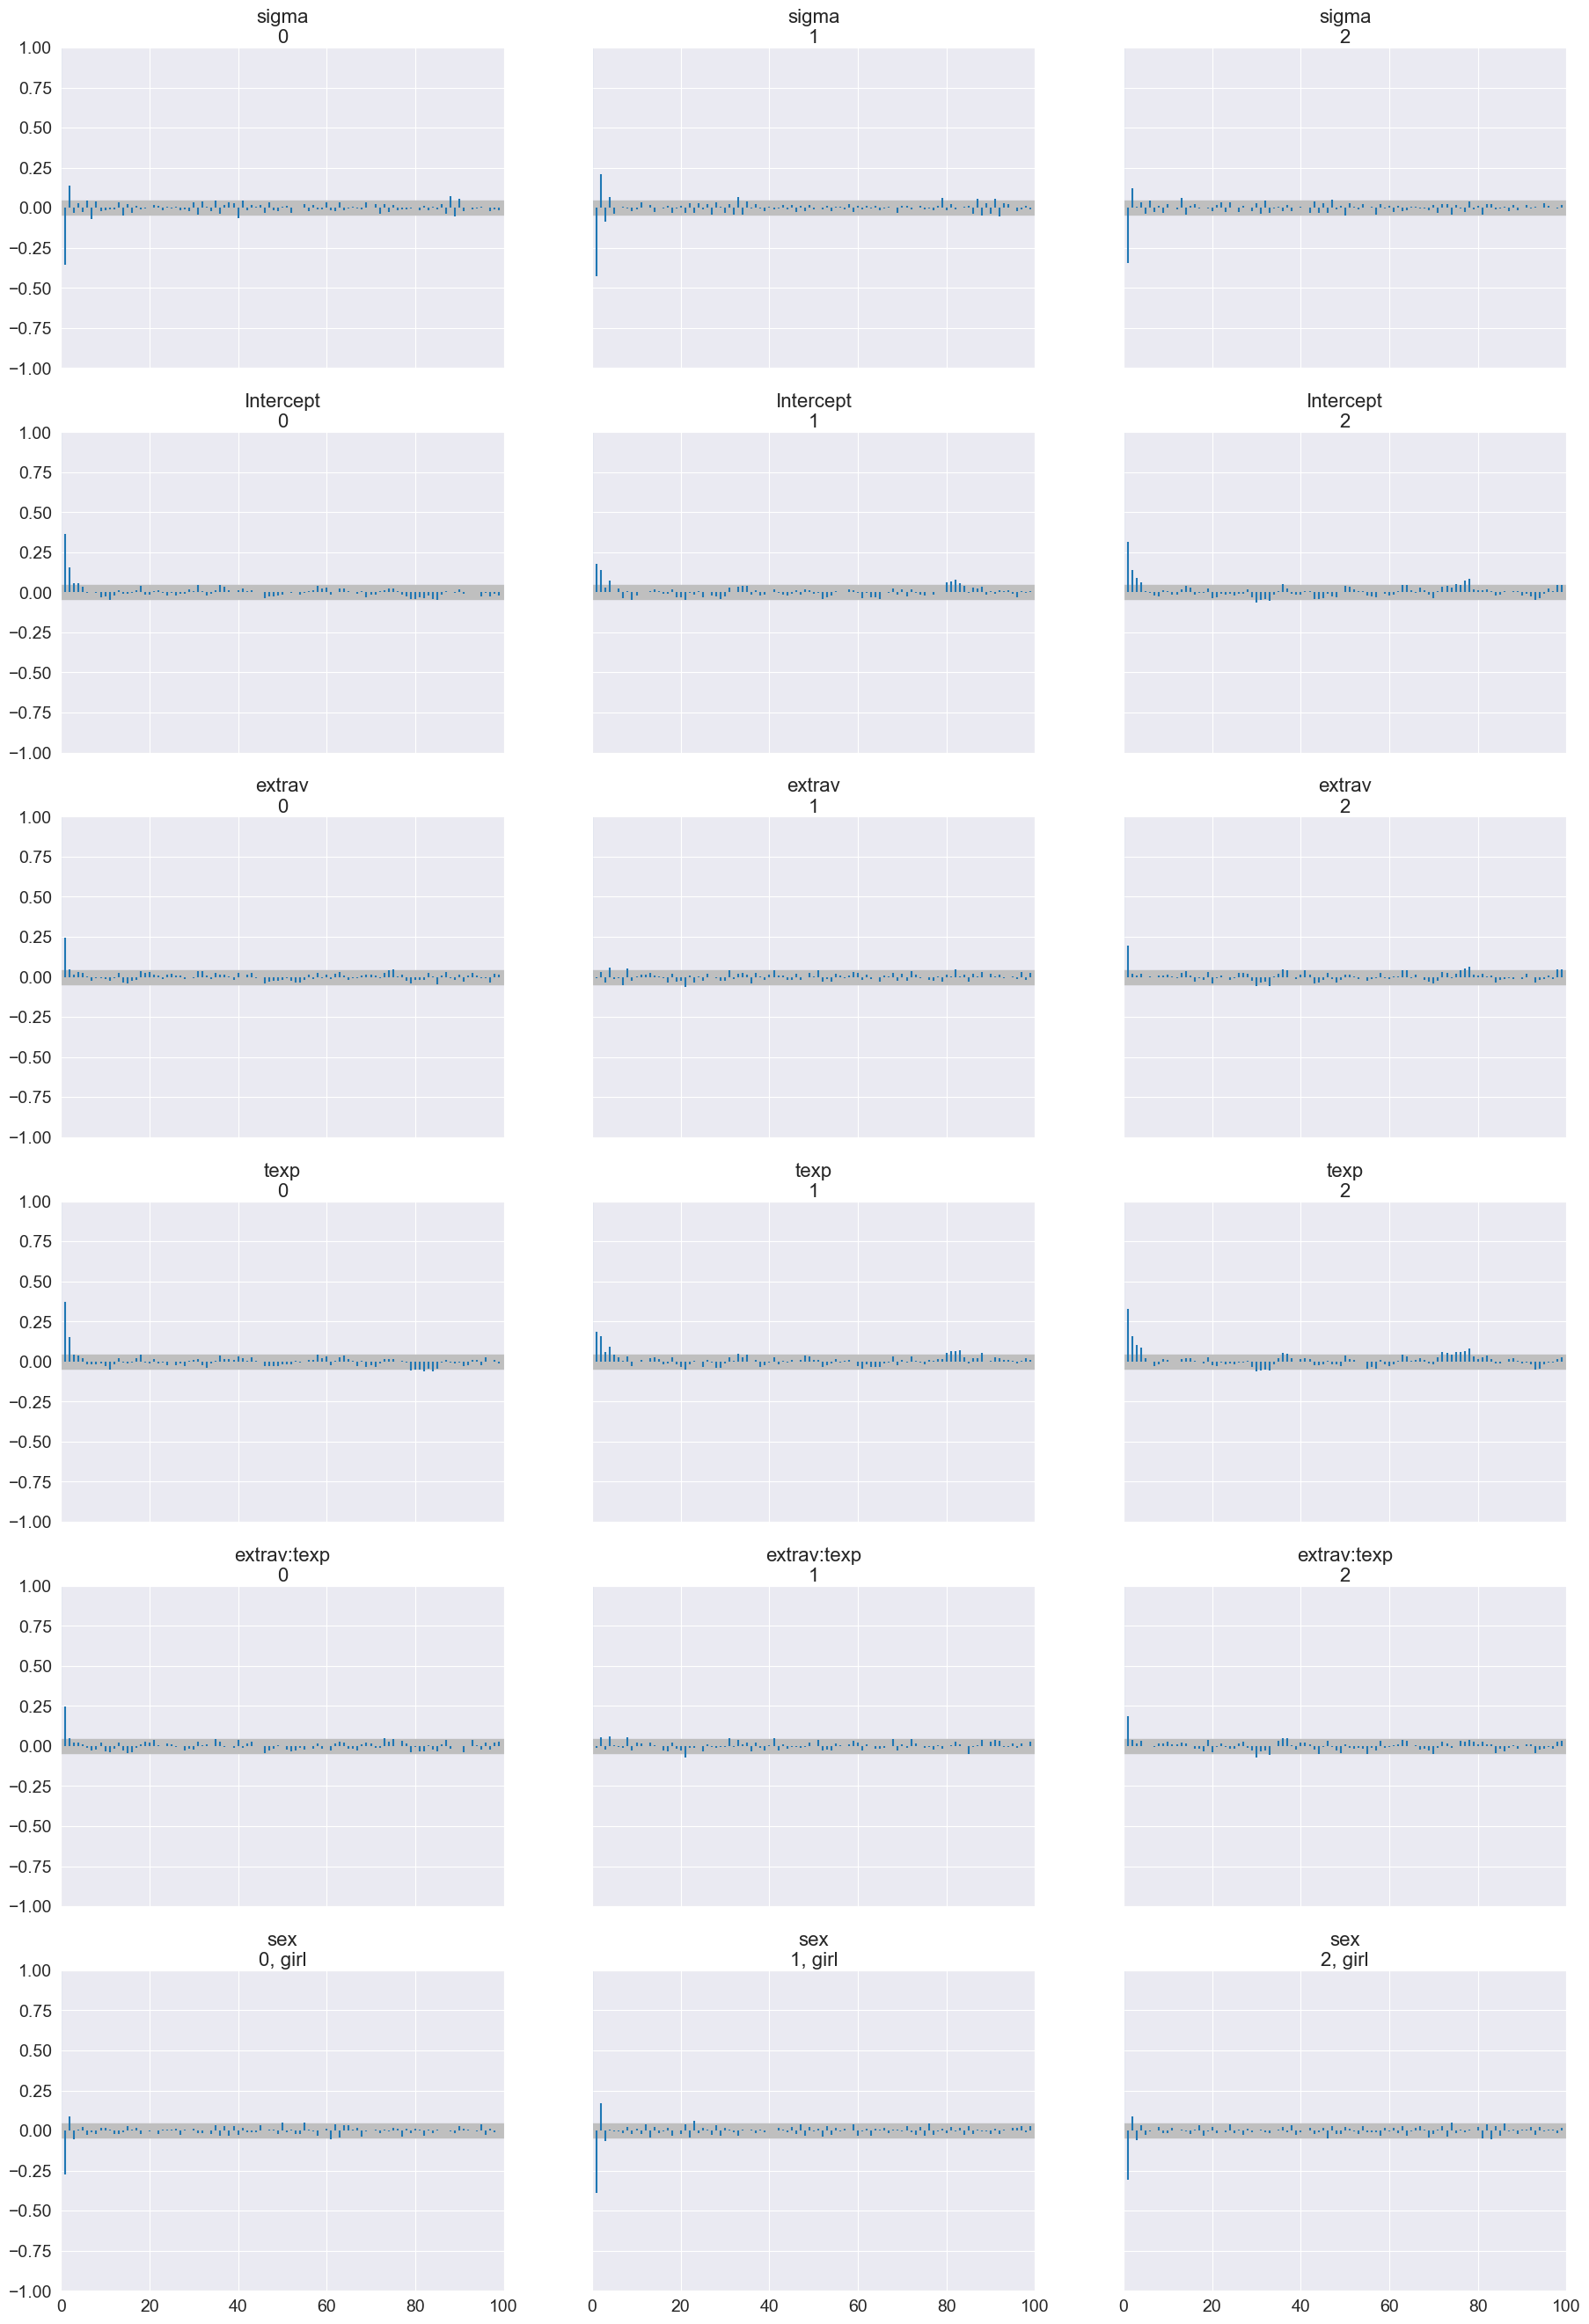

In [30]:
az.plot_autocorr(fit, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

These results show that autocorrelation is quite strong after a few lags. This means it is important to make sure we ran the analysis with a lot of samples, because with a high autocorrelation it will take longer until the whole parameter space has been identified. For more information on autocorrelation check this [paper](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/j.2041-210X.2011.00131.x).

### 6.   Do the posterior distributions make substantive sense?

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'extrav'}>],
       [<Axes: title={'center': 'texp'}>,
        <Axes: title={'center': 'extrav:texp'}>,
        <Axes: title={'center': 'sex\ngirl'}>]], dtype=object)

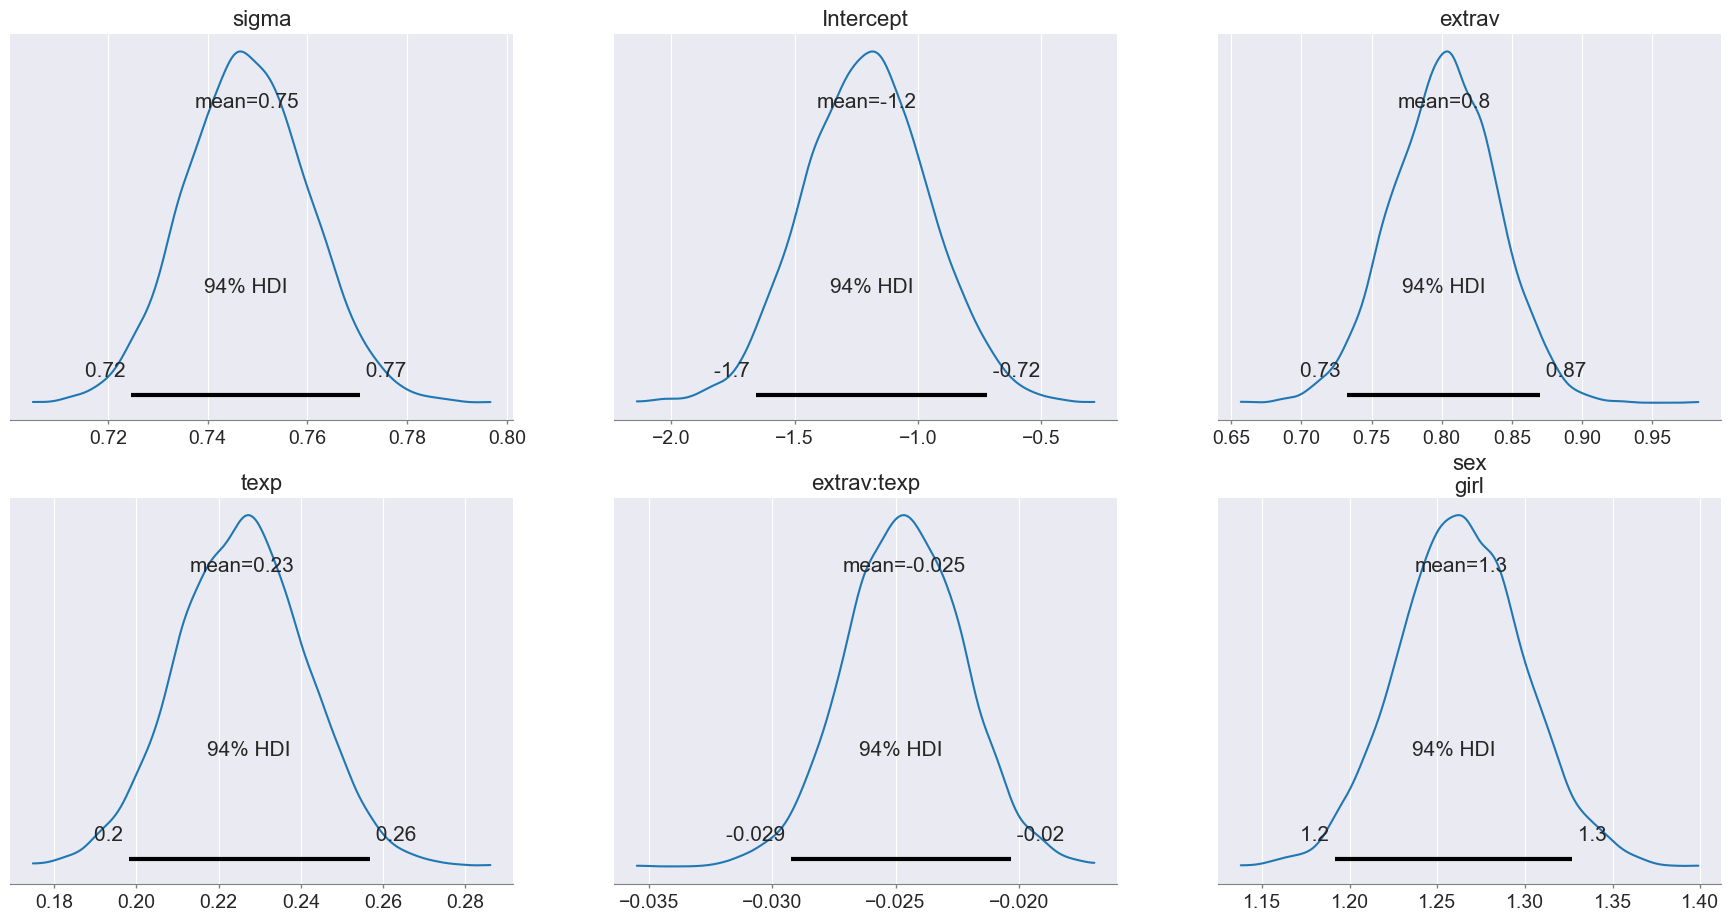

In [40]:
az.plot_posterior(fit, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

### 7. Do different specification of the multivariate variance priors influence the results?

So far we have only set the priors for the regression coefficients and the intercept and have used the default BRMS priors for the standard deviations of group-level ('random') effects named (**sd**), the correlations of group-level ('random') effects (**cor**), and the residual standard deviation (**sigma**).

From the BRMS manual we learn that:

1. The SD *"parameters are restricted to be non-negative and, by default, have a half student-t prior with 3 degrees of freedom and a scale parameter that depends on the standard deviation of the response after applying the link function. Minimally, the scale parameter is 10."*
2.The cor  prior *"lkj_corr_cholesky(eta)" or in short "lkj(eta)" with eta > 0 is essentially the only prior for (Cholesky factors) of correlation matrices. If eta = 1 (the default) all correlations matrices are equally likely a priori. If eta > 1, extreme correlations become less likely, whereas 0 < eta < 1 results in higher probabilities for extreme correlations"*
3. *"By default, sigma has a half student-t prior that scales in the same way as the group-level standard deviations."*

We can re-specify these priors a bit to see if doing so strongly influences the results.


In [42]:
# Define the priors
priors2 = {
    "extrav": bmb.Prior("Normal", mu=0, sigma=5),
    "extrav:texp": bmb.Prior("Normal", mu=-1, sigma=0.3),
    "sex": bmb.Prior("Normal", mu=2, sigma=0.2),
    "texp": bmb.Prior("Normal", mu=0, sigma=5),
    "Intercept": bmb.Prior("Cauchy", alpha=0, beta=10),
    "sigma": bmb.Prior("InverseGamma", alpha=0.5, beta=0.5),
    "sd": bmb.Prior("HalfCauchy", beta=2),
    "cor": bmb.Prior("LKJ", eta=2)
}

# Define the model
model_different_mv_priors = bmb.Model(
    "popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)",
    data=popular2data,
    priors=priors2,
    center_predictors=False
)

# Fit the model
fit_different_mv_priors = model_different_mv_priors.fit(
    draws=2000,
    tune=1000,
    chains=3,
    random_seed=SEED,
    target_accept=0.96
)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, sex, extrav, texp, extrav:texp, 1|class_sigma, 1|class_offset, extrav|class_sigma, extrav|class_offset]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 291 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [ ]:
az.summary(fit_different_mv_priors)

We see that these new priors had little influence on the estimation of the regression coefficients, but we do see that the sds got smaller. This is because the half cauchy prior we used is weakly informative towards 0 compared to the default priors. Also, because we set the correlation prior quite a bit higher we get a lower estimated correlation between the random effects. To quantify these differences, we can also calculate the biases again.

In [43]:
# Get posterior summaries
summary_fit_different_mv_priors = az.summary(fit_different_mv_priors, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

# Extract posterior means
means_fit_different_mv_priors = summary_fit_different_mv_priors["mean"]

# Compute % change
percent_change = 100 * ((means_fit_different_mv_priors - means_fit) / means_fit)
percent_change_rounded = percent_change.round(4)

print(percent_change_rounded)

sigma          0.0000
Intercept     -0.3306
extrav         0.0000
texp          -0.4425
extrav:texp   -0.0000
sex[girl]      0.0792
Name: mean, dtype: float64


### 8.   Is there a notable effect of the prior when compared with non-informative priors?

One might be interested in re-runinng the analysis, but with uninformartive priors simply to check if these priors had a large influence on the estimates. A large influence of informative prior is not per se problematic (even one of the strengths of a Bayesian analysis), but unlikely in a large dataset such as this one. We can specify priors as we did before, using the prior command in the `bambi()` function.


In [44]:
# Define uninformative priors
uninformative_priors = {
    "extrav": bmb.Prior("Normal", mu=0, sigma=100),
    "extrav:texp": bmb.Prior("Normal", mu=0, sigma=100),
    "sex": bmb.Prior("Normal", mu=0, sigma=100),
    "texp": bmb.Prior("Normal", mu=0, sigma=100),
    "Intercept": bmb.Prior("Cauchy", alpha=0, beta=10),
}

# Define the model
model_uninformative = bmb.Model(
    "popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)",
    data=popular2data,
    priors=uninformative_priors,
    center_predictors=False
)

# Fit the model
fit_uninformative = model_uninformative.fit(
    draws=2000,
    tune=1000,
    chains=3,
    random_seed=SEED,
    target_accept=0.96
)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, sex, extrav, texp, extrav:texp, 1|class_sigma, 1|class_offset, extrav|class_sigma, extrav|class_offset]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 192 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
az.summary(fit_uninformative)

We see only a small difference between the informative and uninformative priors. We see that the estimates are 'pulled' toward the mean of the informative priors we specified for the regression coefficients of sex and extrav:texp.

We can also calculate a relative biases again. With the exception of the regression coefficient for sex,  all estimated biases are less than 1%.

In [48]:
# Get posterior summaries
summary_fit_uninformative = az.summary(fit_uninformative, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

# Extract posterior means
means_fit_uninformative = summary_fit_uninformative["mean"]

# Compute % change
percent_change = 100 * ((means_fit_uninformative - means_fit) / means_fit)
percent_change_rounded = percent_change.round(4)

print(percent_change_rounded)

sigma          0.0000
Intercept     -0.3306
extrav         0.1247
texp           0.0000
extrav:texp   -0.0000
sex[girl]     -1.9002
Name: mean, dtype: float64


### 9.   Are the results stable from a sensitivity analysis?

If you still have time left, you can adjust the hyperparameters of the priors upward and downward and re-estimating the model with these varied priors to check for robustness.

From the original paper:

> "If informative or weakly-informative priors are used, then we suggest running a sensitivity analysis of these priors. When subjective priors are in place, then there might be a discrepancy between results using different subjective prior settings. A sensitivity analysis for priors would entail adjusting the entire prior distribution (i.e., using a completely different prior distribution than before) or adjusting hyperparameters upward and downward and re-estimating the model with these varied priors. Several different hyperparameter specifications can be made in a sensitivity analysis, and results obtained will point toward the impact of small fluctuations in hyperparameter values. [.] The purpose of this sensitivity analysis is to assess how much of an impact the location of the mean hyperparameter for the prior has on the posterior. [.] Upon receiving results from the sensitivity analysis, assess the impact that fluctuations in the hyperparameter values have on the substantive conclusions. Results may be stable across the sensitivity analysis, or they may be highly instable based on substantive conclusions. Whatever the finding, this information is important to report in the results and discussion sections of a paper. We should also reiterate here that original priors should not be modified, despite the results obtained."


### 10.   Is the Bayesian way of interpreting and reporting model results used?

For a summary on how to interpret and report models, please refer to https://www.rensvandeschoot.com/bayesian-analyses-where-to-start-and-what-to-report/

In [51]:
az.summary(fit, var_names=["sigma", "Intercept", "extrav", "texp", "extrav:texp", "sex"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.748,0.012,0.726,0.772,0.000,0.000,13121.0,6578.0,1.0
Intercept,-1.210,0.251,-1.684,-0.736,0.004,0.003,3175.0,4987.0,1.0
extrav,0.803,0.037,0.732,0.870,0.001,0.000,4834.0,5270.0,1.0
texp,0.226,0.016,0.196,0.253,0.000,0.000,3141.0,5131.0,1.0
extrav:texp,-0.025,0.002,-0.029,-0.020,0.000,0.000,4841.0,5250.0,1.0
sex[girl],1.263,0.036,1.196,1.332,0.000,0.000,15088.0,6252.0,1.0


In the current model we see that:


- The estimate for the fixed intercept is **-1.21** [-1.71; -0.71]
- The estimate for the fixed effect of sex is **1.26** [1.19; 1.33]
- The estimate for the effect of teacher experience is **0.23** [0.19; 0.26]
- The estimate for the mean (random) effect of extraversion is **0.80** [0.73; 0.87]
- The estimate for the crosslevel interaction effect of extraversion and teacher experience is **-0.03** [-0.03; -0.02]


We can see that none of 95% Posterior Credible Intervals for these effects include zero, which means we are can be quite certain that all of the random and fixed effects are different from 0.



####  References

[Burkner, P. C. (2017). brms: An R package for Bayesian multilevel models using Stan. Journal of Statistical Software, 80(1), 1-28.](https://www.jstatsoft.org/article/view/v080i01)

[Depaoli, S., Van de Schoot, R. (2017). Improving Transparency and Replication in Bayesian Statistics: The WAMBS-Checklist. Psychological Methods, 22(2), 240-261.](https://www.ncbi.nlm.nih.gov/pubmed/26690773)


## Original Computing Environment

In [ ]:
import session_info
session_info.show()